# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

train_emotion_dir = EMOTION_FILE_PATH / 'images/train'
test_emotion_dir = EMOTION_FILE_PATH / 'images/validation'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
        'label': [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH)
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH)
print(gender_df.head())

                                        file_path file_name label
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png   057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png   057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png   057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png   057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png   057
                                           file_path            file_name  \
0  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_112131.jpg   
1  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_133142.jpg   
2  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160304.jpg   
3  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240609_200332.jpg   
4  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160729.jpg   

  label  
0   MEN  
1   MEN  
2   MEN  
3   MEN  
4   MEN  


In [11]:
age_df.shape, gender_df.shape

((19556, 3), (1937, 3))

In [12]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'label']).sum())
gender_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778
646


In [13]:
age_df.shape, gender_df.shape

((9778, 3), (1291, 3))

In [14]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [15]:
gender_df['label'].str.lower()
gender_df.head()

,file_path,file_name,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_112131.jpg,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_133142.jpg,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160304.jpg,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_200332.jpg,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160729.jpg,MEN


In [16]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

file_path         0
file_name         0
label             0
age_category    794
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64


In [17]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [18]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [19]:
train_age_data, test_age_data = train_test_split(age_df, shuffle=True, test_size=0.2)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.2)
train_gender_data.head()

                                           file_path file_name age_category
8003  /kaggle/input/facial-age/face_age/003/7343.png  7343.png        Child
2892  /kaggle/input/facial-age/face_age/006/4413.png  4413.png        Child
6400  /kaggle/input/facial-age/face_age/054/8708.png  8708.png        Adult
6967  /kaggle/input/facial-age/face_age/021/4623.png  4623.png  Young Adult
6972  /kaggle/input/facial-age/face_age/021/9410.png  9410.png  Young Adult


,file_path,file_name,label
1203,/kaggle/input/gender-recognizer/dataset/WOMAN/...,tengrai_image_1718650430_8628962.png,WOMAN
77,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_153923.jpg,MEN
286,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160238.jpg,MEN
862,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0120.jpg,WOMAN
103,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_155209.jpg,MEN


In [20]:
train_age_data.shape, test_age_data.shape

((7187, 3), (1797, 3))

In [21]:
train_gender_data.shape, test_gender_data.shape

((1032, 3), (259, 3))

## 3. Data Transformation for All Dataset

In [22]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for Age and Gender Data

In [23]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, file_paths, categories, idx, transform=None):
        """
        Args:
            file_paths (list): List of image file paths.
            categories (list): List of all categories corresponding to the images.
            idx (dict): Mapping of all categories to numerical indices.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.file_paths = list(file_paths)
        self.categories = list(categories)
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Retrieve image path and age category
        img_path = self.file_paths[idx]
        category = self.categories[idx]

        # Map the age category to its corresponding index
        label_idx = self.idx[category]

        # Load the image
        img = Image.open(img_path)

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [24]:
gender_labels = list(train_gender_data['label'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'WOMAN': 0, 'MEN': 1}

In [25]:
# Initialize the datasets for Age Dataset
age_train_dataset = CustomDataset(
    file_paths=train_age_data['file_path'].tolist(),
    categories=train_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=train_transforms
)

age_test_dataset = CustomDataset(
    file_paths=test_age_data['file_path'].tolist(),
    categories=test_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=test_transforms
)

# Initialize the datasets for Gender Dataset
gender_train_dataset = CustomDataset(
    file_paths=train_gender_data['file_path'].tolist(),
    categories=train_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=train_transforms
)

gender_test_dataset = CustomDataset(
    file_paths=test_gender_data['file_path'].tolist(),
    categories=test_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=test_transforms
)

In [26]:
# Test the training dataset
img, label_idx = age_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 1


In [27]:
# Test the training dataset
img, label_idx = gender_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 0


In [28]:
age_train_dataset[3]

(tensor([[[-0.6452, -0.5596, -0.5253,  ...,  2.2489,  2.2489,  2.2489],
          [-0.6452, -0.5596, -0.5253,  ...,  2.2489,  2.2489,  2.2489],
          [-0.6109, -0.5938, -0.5596,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.0116, -0.0116, -0.0116,  ...,  1.1529,  1.0673,  0.9988],
          [-0.0116, -0.0116,  0.0227,  ...,  1.0844,  0.9988,  0.9132],
          [-0.0116, -0.0116,  0.0227,  ...,  1.0673,  0.9817,  0.8961]],
 
         [[-1.6331, -1.5455, -1.5105,  ...,  2.4286,  2.4286,  2.4286],
          [-1.6331, -1.5455, -1.5105,  ...,  2.4286,  2.4286,  2.4286],
          [-1.5980, -1.5630, -1.5455,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-0.9503, -0.9503, -0.9503,  ...,  1.4482,  1.3606,  1.3081],
          [-0.9503, -0.9503, -0.9153,  ...,  1.3957,  1.3081,  1.2206],
          [-0.9503, -0.9503, -0.9153,  ...,  1.3606,  1.2731,  1.1856]],
 
         [[-1.8044, -1.8044, -1.8044,  ...,  2.6400,  2.6400,  2.6400],
          [-1.8044, -1.8044,

In [29]:
gender_train_dataset[3]

(tensor([[[-2.0494, -1.9809, -1.9124,  ..., -0.8849, -0.8849, -0.8507],
          [-2.0323, -1.9638, -1.8953,  ..., -0.8335, -0.7993, -0.7479],
          [-2.0323, -1.9638, -1.8953,  ..., -0.7479, -0.7137, -0.6623],
          ...,
          [-0.9705, -1.1075, -1.2103,  ..., -1.3130, -1.2959, -1.2445],
          [-0.9705, -1.1075, -1.2274,  ..., -1.3130, -1.2959, -1.2788],
          [-0.9705, -1.1247, -1.2274,  ..., -1.2959, -1.2959, -1.2788]],
 
         [[-1.9307, -1.8606, -1.8081,  ..., -1.1604, -1.1253, -1.0378],
          [-1.9307, -1.8606, -1.7731,  ..., -1.0903, -1.0728, -1.0028],
          [-1.9132, -1.8431, -1.7556,  ..., -1.0028, -0.9853, -0.9328],
          ...,
          [-1.1253, -1.1954, -1.2654,  ..., -1.7381, -1.7556, -1.7556],
          [-1.1253, -1.2129, -1.2829,  ..., -1.7381, -1.7556, -1.7381],
          [-1.1429, -1.2304, -1.2829,  ..., -1.7381, -1.7556, -1.7381]],
 
         [[-1.7870, -1.7347, -1.6476,  ..., -1.1770, -1.1596, -1.0898],
          [-1.7870, -1.7173,

In [30]:
age_train_dataset.idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

In [31]:
gender_train_dataset.idx

{'WOMAN': 0, 'MEN': 1}

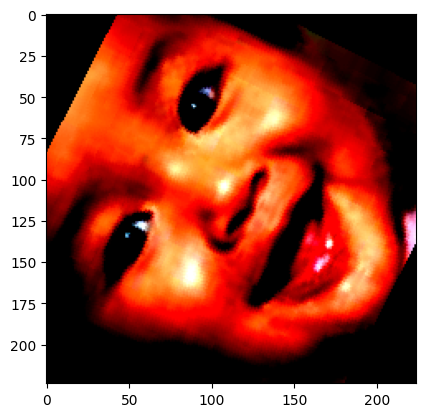

In [32]:
plt.imshow(age_train_dataset[0][0].permute(1, 2, 0))

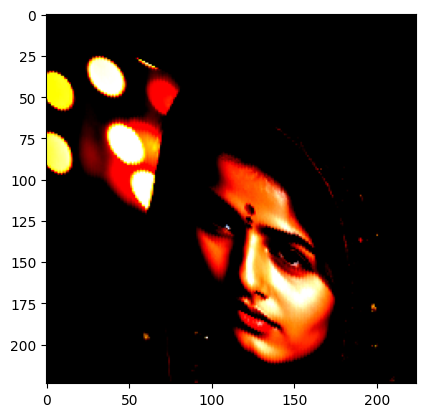

In [33]:
plt.imshow(gender_train_dataset[0][0].permute(1, 2, 0))

In [34]:
import matplotlib.pyplot as plt

# Adjusted display_random_images function
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, label = dataset[idx]
        
        # Convert the tensor to numpy for matplotlib
        img_np = img_tensor.permute(1, 2, 0).numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        
        title = f"Class: {classes[label]}" if classes else f"Label: {label}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title)

    plt.show()

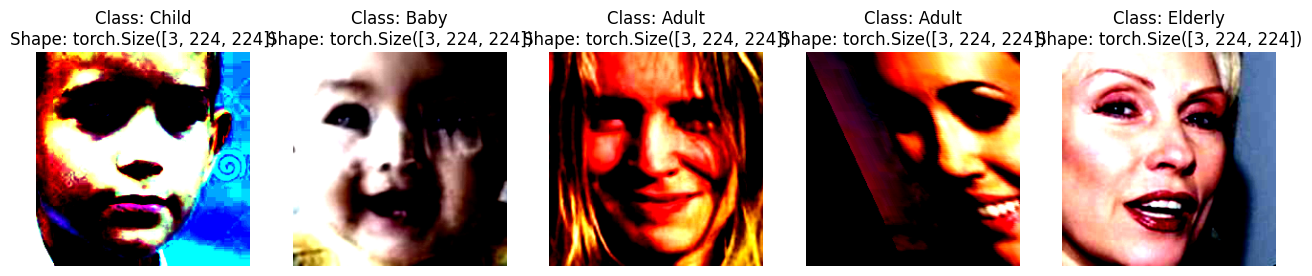

In [35]:
# Display random images from the the Custom Dataset
display_random_images(age_train_dataset, n=5,
                     classes=age_labels, seed=None)

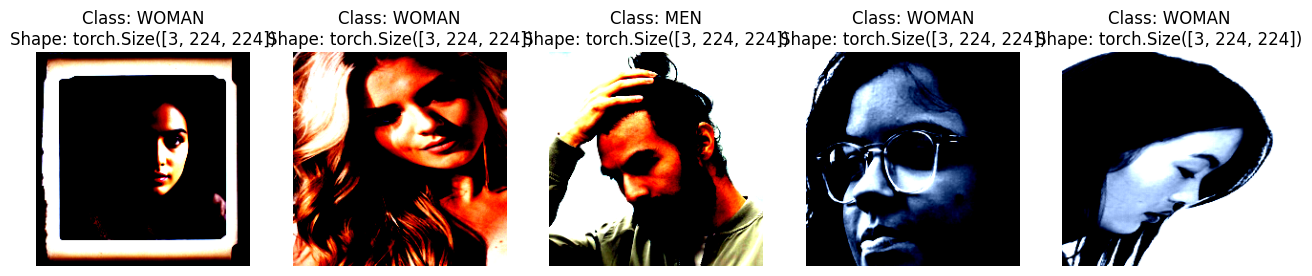

In [36]:
# Display random images from the the Custom Dataset
display_random_images(gender_train_dataset, n=5,
                     classes=gender_labels, seed=None)

### 4.2 Create Emotion Dataset using ImageFolder

In [37]:
# Turn image folders into Datasets
from torchvision import datasets

emotion_train_dataset = datasets.ImageFolder(root=train_emotion_dir,
                                            transform=train_transforms)

emotion_test_dataset = datasets.ImageFolder(root=test_emotion_dir,
                                        transform=test_transforms)

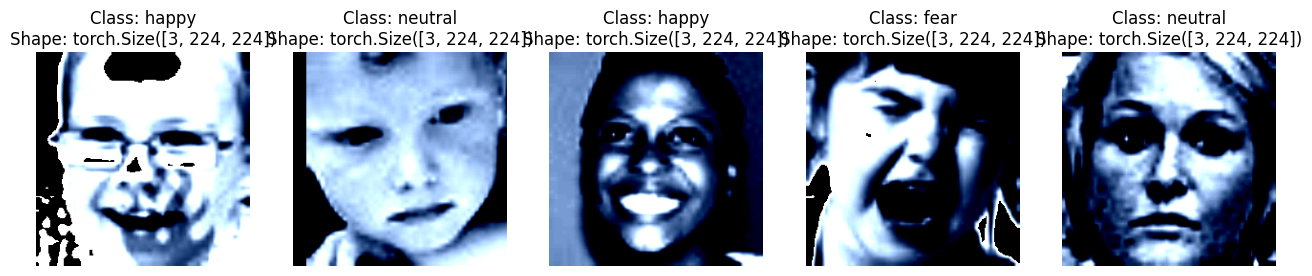

In [38]:
# Display random images from the the Custom Dataset
display_random_images(emotion_train_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

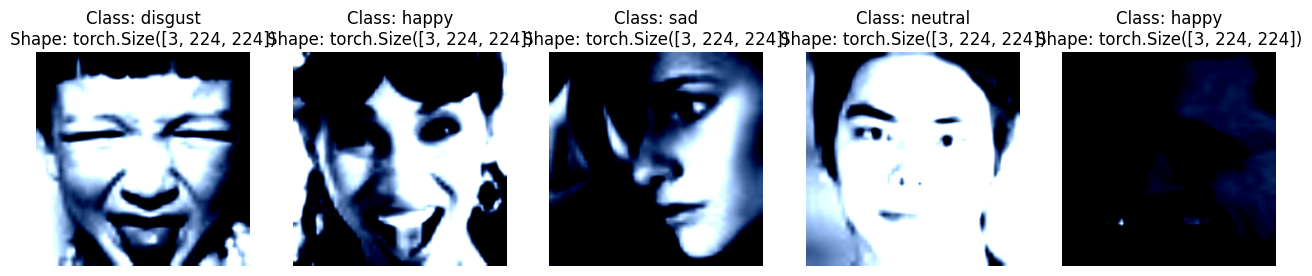

In [39]:
# Display random images from the the Custom Dataset
display_random_images(emotion_test_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

## 5. Turn all Dataset into DataLoader

In [40]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

# Age Dataset
age_train_dataloader = DataLoader(dataset=age_train_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

age_test_dataloader = DataLoader(dataset=age_test_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

# Gender Dataset
gender_train_dataloader = DataLoader(dataset=gender_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

gender_test_dataloader = DataLoader(dataset=gender_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

# Emotion Dataset
emotion_train_dataloader = DataLoader(dataset=emotion_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

emotion_test_dataloader = DataLoader(dataset=emotion_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

In [41]:
emotion_train_dataloader.batch_size

16

## Model Architecture 

In [42]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights


class MultiTaskEfficientNetB0(nn.Module):
    def __init__(self, input_shape: int, 
                 hidden_shape: int, 
                 num_age_bins, 
                 num_emotions,):
        
        super(MultiTaskEfficientNetB0, self).__init__()

        # Shared Backbone
        self.backbone = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone.classifier = nn.Identity()

        # Age Head
        self.age_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.BatchNorm1d(hidden_shape),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_shape, num_age_bins)
        )
        
        # Gender Head
        self.gender_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.BatchNorm1d(hidden_shape),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_shape, 1),
            nn.Sigmoid()
        )
        
        # Emotion Head
        self.emotion_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.BatchNorm1d(hidden_shape),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_shape, num_emotions)
        )

    
    def forward(self, x):
        # Shared features
        features = self.backbone(x)
        
        # Task-specific outputs
        age_output = self.age_head(features)
        gender_output = self.gender_head(features)
        emotion_output = self.emotion_head(features)
        
        return age_output, gender_output, emotion_output 

In [43]:
emotion_idx = emotion_train_dataset.class_to_idx
emotion_idx, age_idx

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 {'Baby': 0,
  'Child': 1,
  'Teen': 2,
  'Young Adult': 3,
  'Adult': 4,
  'Elderly': 5})

In [44]:
NUM_AGE_BINS = len(age_idx)
NUM_EMOTIONS = len(emotion_train_dataset.class_to_idx)
input_shape = 1280
hidden_shape = 256

multitask_model = MultiTaskEfficientNetB0(input_shape=input_shape, 
                                          hidden_shape=hidden_shape, 
                                          num_age_bins=NUM_AGE_BINS, 
                                          num_emotions=NUM_EMOTIONS).to(device)
print(multitask_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


MultiTaskEfficientNetB0(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

## Model Training and Testing

#### Multi-task `train_step` function

In [45]:
def train_step(model: torch.nn.Module,
               dataloaders: dict,
               loss_fns: dict,
               optimizers: dict,
               device=device):

    """
    Performs a single training step for a multi-task model

    Args:
        model (torch.nn.Module): The multi-task model.
        dataloaders (dict): Dictionary of task-specific dataloaders.
        loss_fns (dict): Dictionary of task-specific loss functions.
      optimizers (dict): Dictionary of task-specific optimizers.
      device: Target device for computation.

    Returns:
      train_metrics (dict): Dictionary containing the average loss and accuracy for each task.
    """

    model.train()

    # Initialize metrics
    train_metrics = {task: {
        'loss': 0.0,
        'accuracy': 0.0
    } for task in dataloaders.keys()}


    # Create task-specific iterators
    dataloader_iters = {task: iter(dataloader) for task, dataloader in dataloaders.items()}

    # Loop through the largest dataloader (e.g., "age")
    largest_task = max(dataloaders, key=lambda task: len(dataloaders[task]))
    for batch in dataloaders[largest_task]:
        # Process each task
        for task, dataloader_iter in dataloader_iters.items():
            try:
                X, y = next(dataloader_iter)
            except StopIteration:
                # Restart smaller dataloaders when they are exhausted
                dataloader_iters[task] = iter(dataloaders[task])
                X, y = next(dataloader_iters[task])

            # Send data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            if task == "age":
                y_pred, _, _ = model(X)  # Only age output
            elif task == "gender":
                _, y_pred, _ = model(X)  # Only gender output
                y = y.unsqueeze(1).float()
            elif task == "emotion":
                _, _, y_pred = model(X)  # Only emotion output
            
            # Calculate loss
            loss = loss_fns[task](y_pred, y)
            train_metrics[task]["loss"] += loss.item()

            # Backpropagation and optimization
            optimizers[task].zero_grad()
            loss.backward()
            optimizers[task].step()

            # Calculate accuracy
            if task == "gender":
                y_pred_class = (y_pred > 0.5).int()  # Binary classification
            else:
                y_pred_class = torch.argmax(y_pred, dim=1)  # Multi-class classification
            train_metrics[task]["accuracy"] += (y_pred_class == y).sum().item() / len(y_pred)

    # Compute average metrics
    for task in train_metrics.keys():
        train_metrics[task]["loss"] /= len(dataloaders[task])
        train_metrics[task]["accuracy"] /= len(dataloaders[task])

    return train_metrics

### Multi-task `test_step` function

In [46]:
def test_step(model: torch.nn.Module,
              dataloaders: dict,  # A dictionary of task-specific dataloaders
              loss_fns: dict,     # A dictionary of task-specific loss functions
              device=device):
    """
    Perform a test step for a multi-task model.

    Args:
      model (torch.nn.Module): The multi-task model.
      dataloaders (dict): Dictionary of task-specific dataloaders.
      loss_fns (dict): Dictionary of task-specific loss functions.
      device: Target device for computation.

    Returns:
      test_metrics (dict): Dictionary containing the average loss and accuracy for each task.
    """
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    test_metrics = {task: {"loss": 0.0, "accuracy": 0.0} for task in dataloaders.keys()}

    # Create task-specific iterators
    dataloader_iters = {task: iter(dataloader) for task, dataloader in dataloaders.items()}

    # Turn on inference mode
    with torch.inference_mode():
        # Iterate through the largest dataloader (e.g., "age")
        largest_task = max(dataloaders, key=lambda task: len(dataloaders[task]))
        for batch in dataloaders[largest_task]:
            # Process each task
            for task, dataloader_iter in dataloader_iters.items():
                try:
                    X, y = next(dataloader_iter)
                except StopIteration:
                    # Restart smaller dataloaders when they are exhausted
                    dataloader_iters[task] = iter(dataloaders[task])
                    X, y = next(dataloader_iters[task])

                # Send data to device
                X, y = X.to(device), y.to(device)

                # Forward pass
                if task == "age":
                    y_pred, _, _ = model(X)  # Only age output
                elif task == "gender":
                    _, y_pred, _ = model(X)  # Only gender output
                    y = y.unsqueeze(1).float()
                elif task == "emotion":
                    _, _, y_pred = model(X)  # Only emotion output
                
                # Calculate loss
                loss = loss_fns[task](y_pred, y)
                test_metrics[task]["loss"] += loss.item()

                # Calculate accuracy
                if task == "gender":
                    y_pred_class = (y_pred > 0.5).int()  # Binary classification
                else:
                    y_pred_class = torch.argmax(y_pred, dim=1)  # Multi-class classification
                test_metrics[task]["accuracy"] += (y_pred_class == y).sum().item() / len(y_pred)

    # Compute average metrics
    for task in test_metrics.keys():
        test_metrics[task]["loss"] /= len(dataloaders[task])
        test_metrics[task]["accuracy"] /= len(dataloaders[task])

    return test_metrics

In [47]:
train_dataloaders = {
    'age': age_train_dataloader,
    'gender': gender_train_dataloader,
    'emotion': emotion_train_dataloader,
}

test_dataloaders = {
    'age': age_test_dataloader,
    'gender': gender_test_dataloader,
    'emotion': emotion_test_dataloader,
}

loss_fns = {
    'age': nn.CrossEntropyLoss(),
    'gender': nn.BCELoss(),
    'emotion': nn.CrossEntropyLoss(),
}

optimizers = {
    'age': torch.optim.Adam(multitask_model.parameters(), lr=0.001),
    'gender': torch.optim.Adam(multitask_model.parameters(), lr=0.001),
    'emotion': torch.optim.Adam(multitask_model.parameters(), lr=0.001)
}

In [48]:
from tqdm.auto import tqdm
import torch

def train(model: torch.nn.Module,
          train_dataloaders: dict,  # A dictionary of task-specific train dataloaders
          test_dataloaders: dict,   # A dictionary of task-specific test dataloaders
          optimizers: dict,         # A dictionary of task-specific optimizers
          loss_fns: dict,           # A dictionary of task-specific loss functions
          epochs: int = 5,
          device=device):
    """
    Train and evaluate a multi-task model.

    Args:
      model (torch.nn.Module): The multi-task model.
      train_dataloaders (dict): Dictionary of task-specific train dataloaders.
      test_dataloaders (dict): Dictionary of task-specific test dataloaders.
      optimizers (dict): Dictionary of task-specific optimizers.
      loss_fns (dict): Dictionary of task-specific loss functions.
      epochs (int): Number of epochs to train for.
      device: Target device for computation.

    Returns:
      results (dict): Dictionary containing training and testing losses and accuracies for each task.
    """
    # Initialize results dictionary
    results = {task: {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []} for task in train_dataloaders.keys()}

    # Loop through epochs
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train step
        train_metrics = train_step(model=model,
                                   dataloaders=train_dataloaders,
                                   loss_fns=loss_fns,
                                   optimizers=optimizers,
                                   device=device)
        
        # Test step
        test_metrics = test_step(model=model,
                                 dataloaders=test_dataloaders,
                                 loss_fns=loss_fns,
                                 device=device)
        
        # Print metrics for each task
        for task in train_dataloaders.keys():
            print(f"  {task.capitalize()} - Train Loss: {train_metrics[task]['loss']:.4f}, "
                  f"Train Acc: {train_metrics[task]['accuracy']:.4f}, "
                  f"Test Loss: {test_metrics[task]['loss']:.4f}, "
                  f"Test Acc: {test_metrics[task]['accuracy']:.4f}")

            # Update results dictionary
            results[task]["train_loss"].append(train_metrics[task]["loss"])
            results[task]["train_acc"].append(train_metrics[task]["accuracy"])
            results[task]["test_loss"].append(test_metrics[task]["loss"])
            results[task]["test_acc"].append(test_metrics[task]["accuracy"])

    return results

In [49]:
import torch
torch.cuda.empty_cache()

In [50]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Set number of epochs
# NUM_EPOCHS = 15

# # Start the timer
# from timeit import default_timer as timer

# # Train model
# multitask_model_results = train(model=multitask_model,
#                                 train_dataloaders=train_dataloaders,
#                                 test_dataloaders=test_dataloaders,
#                                 optimizers=optimizers,         # A dictionary of task-specific optimizers
#                                 loss_fns=loss_fns,           # A dictionary of task-specific loss functions
#                                 epochs=NUM_EPOCHS,
#                                 device=device)

# # End the timer and print out how long it took
# end_time = timer()
# print(f'Total training time: {end_time-start_time:3f} seconds')